In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
from scipy.signal import butter, filtfilt, freqz
import shutil
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from plot import plot_individual_areas
from up_down import get_up_down
from utils import compile_folder, get_data_class, get_result_path, load, save

In [7]:
def plot_result(session, VAR_results_dir, window, stride, start_time=120, end_time=None):
    all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
    
    data_class = get_data_class(session, all_data_dir)
    save_dir = f"/om/user/eisenaj/ChaoticConsciousness/plots/{data_class}/VAR/{session}"
    os.makedirs(save_dir, exist_ok=True)

    # LOAD NEURAL DATA    
    filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
    print("Loading data ...")
    start = time.process_time()
    electrode_info, session_info = loadmat(filename, variables=['electrodeInfo', 'sessionInfo'], verbose=False)
    spike_times = spike_times[0]
    dt = lfp_schema['smpInterval'][0]
    # T = lfp.shape[0]

    print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")
    
    # LOAD VAR RESULTS
    VAR_results = {}
    for file in tqdm(os.listdir(VAR_results_dir)):
        try:
            VAR_results[file] = load(os.path.join(VAR_results_dir, file))
        except IsADirectoryError:
            print(f"Need to compile {os.path.join(VAR_results_dir, file)}")
            # compile results
            VAR_results[file] = compile_folder(os.path.join(VAR_results_dir, file))
    
    # PLOT INDIVIDUAL AREAS
    save_path = os.path.join(save_dir, f"VAR_individual_areas_window_{window}_stride_{stride}.png")
    individual_criticalities = plot_individual_areas(session, data_class, VAR_results, window, stride, session_info, save_path=save_path, start_time=start_time, end_time=end_time, return_criticalities=True)
    
    # PLOT MULTIPOPULATION
    save_path = os.path.join(save_dir, f"VAR_multipop_window_{window}_stride_{stride}.png")
    multipop_criticalities = plot_multipopulation(session, data_class, VAR_results, window, stride, session_info, electrode_info, save_path=save_path, start_time=start_time, end_time=end_time, return_criticalities=True)
    
#     # PLOT CRITICALITY DISTRIBUTION
#     lw = 6
#     rows = 3
#     cols = 2
#     fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
#     for i, area in enumerate(VAR_results.keys()):
#         ax = axs[int(i/cols)][i % cols]

#         bin_nums = 20
#         bin_min = np.concatenate(VAR_results[area].criticality_inds.to_numpy()).min()
# #         bin_min = 0.88
# #         if area == 'all':
# #             bin_min = 0.85
# #         elif area == 'Thal':
# #             bin_min = 0.98
#         bin_max = np.concatenate(VAR_results[area].criticality_inds.to_numpy()).max()
# #         bin_max = 1.03
# #         if area == 'Thal':
# #             bin_max = 1.01
#         bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
#         criticality_prob_dist = np.zeros((VAR_results[area].criticality_inds.shape[0], bin_nums))
#         for t in range(VAR_results[area].criticality_inds.shape[0]):
#             criticality_prob_dist[t] = np.histogram(VAR_results[area].criticality_inds[t], bins=bins)[0]

#         im = ax.pcolormesh(criticality_prob_dist.T, cmap='hot')
#         start_times = np.arange(VAR_results[area].criticality_inds.shape[0])*stride/60
#         T_max = VAR_results[area].criticality_inds.shape[0]*stride/60
#         ax.set_xticks([int(i*60/stride) for i in np.arange(0, T_max, 20)], [int(i) for i in np.arange(0, T_max, 20)])
#         ax.set_yticks(np.arange(0, 21, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, 21, 2)]])
#         ax.tick_params(labelsize=13)
#         ax.set_xlabel("Time (min)", fontsize=14)
#         ax.set_ylabel("Criticality Index", fontsize=14)
#         ax.set_title(f"{area}", fontsize=18)
#         ax.axvline(session_info['eyesClose'][-1]/stride if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/stride, linestyle='--', lw=lw, c='red', label="loss of consciousness")
#         ax.axvline(session_info['eyesOpen'][-1]/stride if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/stride, linestyle='--', lw=lw, c='green', label="return of consciousness")
#         ax.axvline(session_info['drugStart'][0]/stride, color='plum', linestyle='--', lw=lw, label=f"drug infusion 1 start - dose = {session_info['drugDose'][0]}")
#         ax.axvline(session_info['drugStart'][1]/stride, color='darkorchid', linestyle='--', lw=lw, label=f"drug infusion 2 start - dose = {session_info['drugDose'][1]}")
#         ax.axvline(session_info['drugEnd'][1]/stride, color='purple', linestyle='--', lw=lw, label=f"drug infusion 2 end")
#         handles, labels = ax.get_legend_handles_labels()
#         # ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
#         #     min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][1]}")
#     #     ax.legend(fontsize=14, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True)
#     #     plt.colorbar(label="Number of modes")
    
#     # PLOT vlPFC from MULTIPOP
#     ax = axs[2][1]
#     unit_indices = np.where(electrode_info['area'] == 'vlPFC')[0]
#     bin_nums = 20
#     criticality_inds = np.zeros((len(VAR_results['all']), len(unit_indices)))
#     for t in range(len(VAR_results['all'])):
#         e, _ = np.linalg.eig(VAR_results['all'].A_mat.iloc[t][unit_indices][:, unit_indices])
#         criticality_inds[t] = np.abs(e)
#     bin_min = criticality_inds.min()
#     #         bin_min = 0.88
#     #         if area == 'all':
#     #             bin_min = 0.85
#     #         elif area == 'Thal':
#     #             bin_min = 0.98
#     bin_max = criticality_inds.max()
#     #         bin_max = 1.03
#     #         if area == 'Thal':
#     #             bin_max = 1.01
#     bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
#     criticality_prob_dist = np.zeros((criticality_inds.shape[0], bin_nums))
#     for t in range(criticality_inds.shape[0]):
#         criticality_prob_dist[t] = np.histogram(criticality_inds[t], bins=bins)[0]

#     im = ax.pcolormesh(criticality_prob_dist.T, cmap='hot')
#     start_times = np.arange(VAR_results[area].criticality_inds.shape[0])*stride/60
#     T_max = VAR_results[area].criticality_inds.shape[0]*stride/60
#     ax.set_xticks([int(i*60/stride) for i in np.arange(0, T_max, 20)], [int(i) for i in np.arange(0, T_max, 20)])
#     ax.set_yticks(np.arange(0, 21, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, 21, 2)]])
#     ax.tick_params(labelsize=13)
#     ax.set_xlabel("Time (min)", fontsize=14)
#     ax.set_ylabel("Criticality Index", fontsize=14)
#     ax.set_title(f"vlPFC Multipop", fontsize=18)
#     ax.axvline(session_info['eyesClose'][-1]/stride if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/stride, linestyle='--', lw=lw, c='red', label="loss of consciousness")
#     ax.axvline(session_info['eyesOpen'][-1]/stride if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/stride, linestyle='--', lw=lw, c='green', label="return of consciousness")
#     ax.axvline(session_info['drugStart'][0]/stride, color='plum', linestyle='--', lw=lw, label=f"drug infusion 1 start - dose = {session_info['drugDose'][0]}")
#     ax.axvline(session_info['drugStart'][1]/stride, color='darkorchid', linestyle='--', lw=lw, label=f"drug infusion 2 start - dose = {session_info['drugDose'][1]}")
#     ax.axvline(session_info['drugEnd'][1]/stride, color='purple', linestyle='--', lw=lw, label=f"drug infusion 2 end")
#     handles, labels = ax.get_legend_handles_labels()

#     plt.suptitle(f"Distribution of Criticality Indices From VAR\n{window} s Windows", fontsize=19)
#     fig.tight_layout()
#     cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
#     cb = fig.colorbar(im, cax=cbar_ax)
#     cb.set_label(label='# modes', fontsize=14)
#     fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True)
#     plt.savefig(os.path.join(save_dir, f"VAR_criticality_dists_window_{window}_stride_{stride}.png"))
#     plt.close()

    
#     start_anesthesia = int(session_info['drugStart'][0]/stride)
#     start_anesthesia -= start_ind
#     sleep_time = int(session_info['eyesClose'][-1]/stride) if isinstance(session_info['eyesClose'], np.ndarray) else int(session_info['eyesClose']/stride)
#     sleep_time -= start_ind
#     wake_time = int(session_info['eyesOpen'][-1]/stride) if isinstance(session_info['eyesOpen'], np.ndarray) else int(session_info['eyesOpen']/stride)
#     wake_time -= start_ind
    
    return individual_criticalities, multipop_criticalities 

## Load All Completed Sessions

In [4]:
# data_dir = "/om/user/eisenaj/datasets/anesthesia/mat/propofolPuffTone"
# results_dir = "/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/VAR"
data_dir = "/om/user/eisenaj/datasets/anesthesia/mat/ketamine"
results_dir = "/om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR"
window = 2.5
stride = 2.5
task_type = 'VAR'
data_file_regex = re.compile(".*.mat")
data_files = [f for f in os.listdir(data_dir) if data_file_regex.match(f)]

results_to_process = []
for data_file in data_files:
    session = data_file[:-4]
    try:
        result_path = get_result_path(results_dir, session, window, stride)
        results_to_process.append((session, result_path))
    except:
        pass

  0%|          | 0/8 [00:00<?, ?it/s]

Loading data ...
Data loaded (took 7.11 seconds)


  0%|          | 0/6 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_MrJones-Anesthesia-20161006-03_window_2.5_stride_2.5_Feb-07-2022_1749/vlPFC


  0%|          | 0/1707 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_MrJones-Anesthesia-20161006-03_window_2.5_stride_2.5_Feb-07-2022_1749/CPB


  0%|          | 0/1707 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/tmp/ipykernel_19712/1560488819.py", line 6, in <module>
    individual_criticalities[session], multipop_criticalities[session], start_anesthesia, sleep_time, wake_time = plot_result(session, VAR_results_dir, window, stride)
  File "/tmp/ipykernel_19712/480064107.py", line 55, in plot_result
    ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60,
TypeError: 'float' object is not subscriptable


Loading data ...
Data loaded (took 5.72 seconds)


  0%|          | 0/6 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/tmp/ipykernel_19712/1560488819.py", line 6, in <module>
    individual_criticalities[session], multipop_criticalities[session], start_anesthesia, sleep_time, wake_time = plot_result(session, VAR_results_dir, window, stride)
  File "/tmp/ipykernel_19712/480064107.py", line 215, in plot_result
    sleep_time = int(session_info['eyesClose'][-1]/stride) if isinstance(session_info['eyesClose'], np.ndarray) else int(session_info['eyesClose']/stride)
ValueError: cannot convert float NaN to integer


Loading data ...
Data loaded (took 5.88 seconds)


  0%|          | 0/6 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/tmp/ipykernel_19712/1560488819.py", line 6, in <module>
    individual_criticalities[session], multipop_criticalities[session], start_anesthesia, sleep_time, wake_time = plot_result(session, VAR_results_dir, window, stride)
  File "/tmp/ipykernel_19712/480064107.py", line 215, in plot_result
    sleep_time = int(session_info['eyesClose'][-1]/stride) if isinstance(session_info['eyesClose'], np.ndarray) else int(session_info['eyesClose']/stride)
ValueError: cannot convert float NaN to integer


Loading data ...
Data loaded (took 5.72 seconds)


  0%|          | 0/6 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/tmp/ipykernel_19712/1560488819.py", line 6, in <module>
    individual_criticalities[session], multipop_criticalities[session], start_anesthesia, sleep_time, wake_time = plot_result(session, VAR_results_dir, window, stride)
  File "/tmp/ipykernel_19712/480064107.py", line 55, in plot_result
    ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60,
TypeError: 'float' object is not subscriptable


Loading data ...
Data loaded (took 5.19 seconds)


  0%|          | 0/6 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_MrJones-Anesthesia-20160808-01_window_2.5_stride_2.5_Feb-07-2022_1840/vlPFC


  0%|          | 0/2416 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_MrJones-Anesthesia-20160808-01_window_2.5_stride_2.5_Feb-07-2022_1840/CPB


  0%|          | 0/2416 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/tmp/ipykernel_19712/1560488819.py", line 6, in <module>
    individual_criticalities[session], multipop_criticalities[session], start_anesthesia, sleep_time, wake_time = plot_result(session, VAR_results_dir, window, stride)
  File "/tmp/ipykernel_19712/480064107.py", line 55, in plot_result
    ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60,
TypeError: 'float' object is not subscriptable


Loading data ...
Data loaded (took 4.33 seconds)


  0%|          | 0/6 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_Mary-Anesthesia-20170411-02_window_2.5_stride_2.5_Feb-07-2022_1848/FEF


  0%|          | 0/2369 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_Mary-Anesthesia-20170411-02_window_2.5_stride_2.5_Feb-07-2022_1848/7b


  0%|          | 0/2369 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_Mary-Anesthesia-20170411-02_window_2.5_stride_2.5_Feb-07-2022_1848/all


  0%|          | 0/2369 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_Mary-Anesthesia-20170411-02_window_2.5_stride_2.5_Feb-07-2022_1848/Thal


  0%|          | 0/2369 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_Mary-Anesthesia-20170411-02_window_2.5_stride_2.5_Feb-07-2022_1848/vlPFC


  0%|          | 0/2369 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_Mary-Anesthesia-20170411-02_window_2.5_stride_2.5_Feb-07-2022_1848/CPB


  0%|          | 0/2369 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/tmp/ipykernel_19712/1560488819.py", line 6, in <module>
    individual_criticalities[session], multipop_criticalities[session], start_anesthesia, sleep_time, wake_time = plot_result(session, VAR_results_dir, window, stride)
  File "/tmp/ipykernel_19712/480064107.py", line 215, in plot_result
    sleep_time = int(session_info['eyesClose'][-1]/stride) if isinstance(session_info['eyesClose'], np.ndarray) else int(session_info['eyesClose']/stride)
ValueError: cannot convert float NaN to integer


Loading data ...
Data loaded (took 5.43 seconds)


  0%|          | 0/6 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_Mary-Anesthesia-20170329-02_window_2.5_stride_2.5_Feb-07-2022_1904/FEF


  0%|          | 0/2492 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_Mary-Anesthesia-20170329-02_window_2.5_stride_2.5_Feb-07-2022_1904/7b


  0%|          | 0/2492 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_Mary-Anesthesia-20170329-02_window_2.5_stride_2.5_Feb-07-2022_1904/all


  0%|          | 0/2492 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_Mary-Anesthesia-20170329-02_window_2.5_stride_2.5_Feb-07-2022_1904/Thal


  0%|          | 0/2492 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_Mary-Anesthesia-20170329-02_window_2.5_stride_2.5_Feb-07-2022_1904/vlPFC


  0%|          | 0/2492 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_Mary-Anesthesia-20170329-02_window_2.5_stride_2.5_Feb-07-2022_1904/CPB


  0%|          | 0/2492 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/tmp/ipykernel_19712/1560488819.py", line 6, in <module>
    individual_criticalities[session], multipop_criticalities[session], start_anesthesia, sleep_time, wake_time = plot_result(session, VAR_results_dir, window, stride)
  File "/tmp/ipykernel_19712/480064107.py", line 215, in plot_result
    sleep_time = int(session_info['eyesClose'][-1]/stride) if isinstance(session_info['eyesClose'], np.ndarray) else int(session_info['eyesClose']/stride)
ValueError: cannot convert float NaN to integer


Loading data ...
Data loaded (took 4.85 seconds)


  0%|          | 0/6 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_MrJones-Anesthesia-20160805-01_window_2.5_stride_2.5_Feb-07-2022_1912/FEF


  0%|          | 0/1587 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_MrJones-Anesthesia-20160805-01_window_2.5_stride_2.5_Feb-07-2022_1912/7b


  0%|          | 0/1587 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_MrJones-Anesthesia-20160805-01_window_2.5_stride_2.5_Feb-07-2022_1912/all


  0%|          | 0/1587 [00:00<?, ?it/s]

Need to compile /om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_MrJones-Anesthesia-20160805-01_window_2.5_stride_2.5_Feb-07-2022_1912/Thal


  0%|          | 0/1587 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/tmp/ipykernel_19712/480064107.py", line 23, in plot_result
    VAR_results[file] = load(os.path.join(VAR_results_dir, file))
  File "../../../utils.py", line 212, in load
    with open(filepath, 'rb') as handle:
IsADirectoryError: [Errno 21] Is a directory: '/om/user/eisenaj/ChaoticConsciousness/results/ketamine/VAR/VAR_MrJones-Anesthesia-20160805-01_window_2.5_stride_2.5_Feb-07-2022_1912/Thal'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_19712/1560488819.py", line 6, in <module>
    individual_criticalities[session], multipop_criticalities[session], start_anesthesia, sleep_time, wake_time = plot_result(session, VAR_results_dir, window, stride)
  File "/tmp/ipykernel_19712/480064107.py", line 27, in plot_result
    VAR_results[file] = compile_folder(os.path.join(VAR_results_dir, file))
  File "../../../utils.py", line 230, in compile_folder
    shutil.rmtree(fo

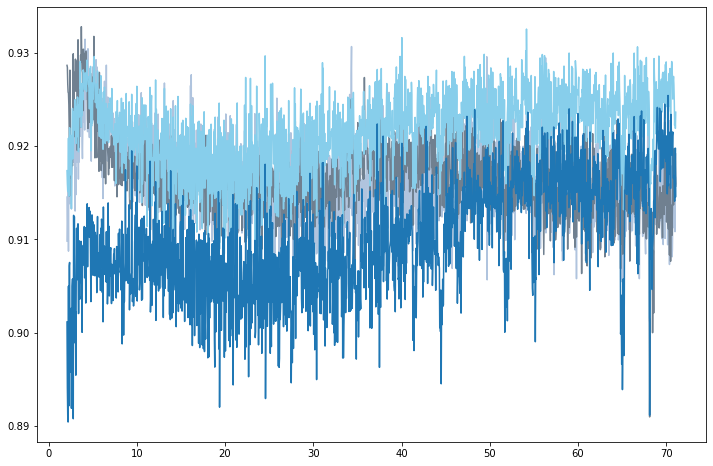

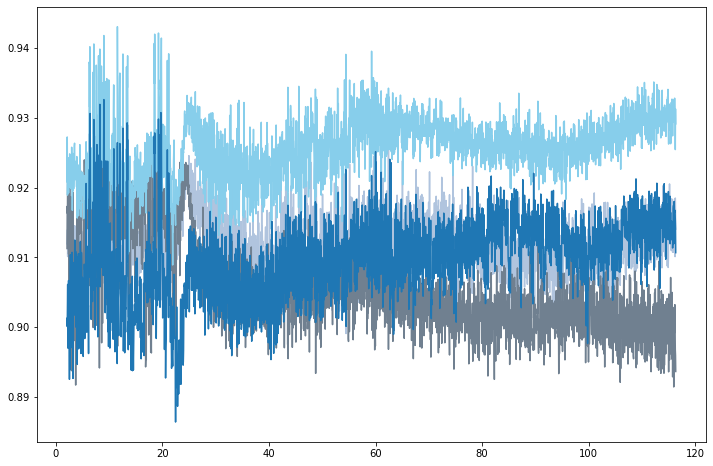

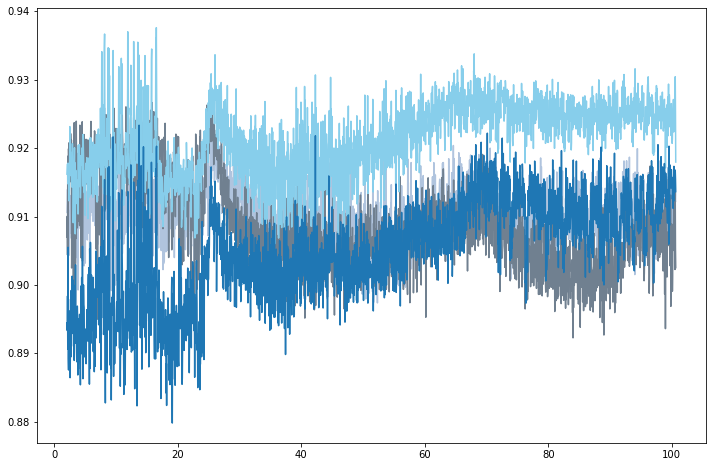

In [5]:
individual_criticalities = {}
multipop_criticalities = {}

for session, VAR_results_dir in tqdm(results_to_process):
    try:
        individual_criticalities[session], multipop_criticalities[session], start_anesthesia, sleep_time, wake_time = plot_result(session, VAR_results_dir, window, stride)
    except:
        tb.print_exc()

In [8]:
individual_criticalities[session]['vlPFC'][:start_anesthesia].mean()

0.8958138915916349

In [70]:
individual_criticalities[session]['vlPFC'][sleep_time:wake_time].mean()

0.932932040464869

In [71]:
multipop_criticalities[session]['vlPFC'][:start_anesthesia].mean()

0.8537944120848371

In [72]:
multipop_criticalities[session]['vlPFC'][sleep_time:wake_time].mean()

0.8714641062022334

In [34]:
session = results_to_process[0][0]
VAR_results_dir = results_to_process[0][1]

all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
    
data_class = get_data_class(session, all_data_dir)
save_dir = f"/om/user/eisenaj/ChaoticConsciousness/plots/{data_class}/VAR/{session}"
os.makedirs(save_dir, exist_ok=True)

# LOAD NEURAL DATA    
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
# T = lfp.shape[0]

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

# LOAD VAR RESULTS
VAR_results = {}
for file in tqdm(os.listdir(VAR_results_dir)):
    try:
        VAR_results[file] = load(os.path.join(VAR_results_dir, file))
    except IsADirectoryError:
        print(f"Need to compile {os.path.join(VAR_results_dir, file)}")
        # compile results
        VAR_results[file] = compile_folder(os.path.join(VAR_results_dir, file))

Loading data ...
Data loaded (took 155.49 seconds)


  0%|          | 0/5 [00:00<?, ?it/s]

In [35]:
len(electrode_info['area'])

227